In [1]:
from matplotlib import image
import numpy as np
import tensorflow as tf
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential, load_model
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.metrics import top_k_categorical_accuracy
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
!unzip drive/MyDrive/AML_project/train.zip > /dev/null
!unzip drive/MyDrive/AML_project/test.zip > /dev/null

!cp "/content/drive/MyDrive/AML_project/list/train.txt" "train.txt"
!cp "/content/drive/MyDrive/AML_project/list/groundtruth.txt" "groundtruth.txt"

replace train/herbarium/148977/291355.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
replace test/11765.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [4]:
def convert_image_to_numpy(image_paths_arr):
  dataset_nparr = list()

  for path in image_paths_arr:
    image_data = image.imread(path)
    image_data = tf.cast(image_data, tf.float32)/255
    image_data = tf.image.resize(image_data, (128, 128), method = "bilinear")
    dataset_nparr.append(image_data)

  return np.array(dataset_nparr)

In [5]:
def encode_labels(labels_arr):
  label_encoder = LabelEncoder()
  return label_encoder.fit_transform(labels_arr)

In [6]:
def load_data(text_file):
  with open(text_file) as txt_file:
    # read the file, with format "path label"
    # e.g. train/photo/106023/1769.jpg 106023
    lines_arr = [line.strip() for line in txt_file.readlines()]

    # split the lines to image path and label
    image_paths = [line.split(' ')[0] for line in lines_arr]
    labels = [line.split(' ')[1] for line in lines_arr]
    x_data = convert_image_to_numpy(image_paths)
    y_data = encode_labels(labels)

    return x_data, y_data

In [7]:
# Load train data
x_train, y_train = load_data("train.txt")

In [8]:
#Undersampling train data
ReX_train = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2] * x_train.shape[3])
print(ReX_train.shape)
#rus = RandomUnderSampler(sampling_strategy=1) # Numerical value
ros = RandomOverSampler(sampling_strategy="not majority") # String
x_train, y_train = ros.fit_resample(ReX_train, y_train)

(4744, 49152)


In [9]:
# Load test data
x_test, y_test = load_data("groundtruth.txt")

In [10]:
#Undersampling test data
ReX_test = x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2] * x_test.shape[3])
print(ReX_test.shape)
#rus = RandomUnderSampler(sampling_strategy=1) # Numerical value
ros = RandomOverSampler(sampling_strategy="not majority") # String
x_test, y_test = ros.fit_resample(ReX_test, y_test)

(207, 49152)


In [11]:
x_train = x_train.reshape(x_train.shape[0], 128, 128, 3)
x_test = x_test.reshape(x_test.shape[0], 128, 128, 3)

In [12]:
# Check data shape
print("Shapes Checking")
print("X-train: " + str(x_train.shape))
print("y-train: " + str(y_train.shape))
print("X-test: " + str(x_test.shape))
print("y-test: " + str(y_test.shape))

Shapes Checking
X-train: (5000, 128, 128, 3)
y-train: (5000,)
X-test: (300, 128, 128, 3)
y-test: (300,)


In [13]:
# Normalize and reshape the data
nRows,nCols,nDims = x_train.shape[1:]
x_train = x_train.reshape(x_train.shape[0], nRows, nCols, nDims)
input_shape = (nRows, nCols, nDims)

nRows,nCols,nDims = x_test.shape[1:]
x_test = x_test.reshape(x_test.shape[0], nRows, nCols, nDims)

print("Reshape Checking")
print("X-train: " + str(x_train.shape))
print("X-test: " + str(x_test.shape))

Reshape Checking
X-train: (5000, 128, 128, 3)
X-test: (300, 128, 128, 3)


In [14]:
classes = np.unique(y_train)
nClasses = len(classes)


In [15]:
# Image data generator (data augmentation)
datagen = ImageDataGenerator(horizontal_flip=True,
                            rotation_range=45,
                            zoom_range=0.8,
                            vertical_flip=True)

datagen.fit(x_train)

In [16]:
# Create Model
def createModel():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), kernel_regularizer=regularizers.L1L2(l1=0.01, l2=0.01), activation='relu', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
 
    model.add(Conv2D(16, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(nClasses, activation='softmax'))
    
    return model

In [17]:
# Call Create Model
cnn_model = createModel()

# Show model summary
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 32)      18464     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 16)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 30, 30, 16)        0

In [18]:
def top_5_categorical_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy (y_true, y_pred, k=5)

In [19]:
# Compile and fit Adam model
checkpoint = ModelCheckpoint("base_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq= 'epoch')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=50, verbose=1, mode='auto')
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001)
cnn_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy', top_5_categorical_accuracy])
batch_size = 32
steps_per_epoch = int( np.ceil(x_train.shape[0] / batch_size) )
initial_epochs = 100
history = cnn_model.fit(datagen.flow(x_train, y_train), batch_size=batch_size, steps_per_epoch = steps_per_epoch,
              epochs=initial_epochs, verbose=1, validation_data= (x_test, y_test), callbacks = [early, checkpoint])

Epoch 1/100
157/157 [==============================] - ETA: 0s - loss: 5.5225 - accuracy: 0.0100 - top_5_categorical_accuracy: 0.0000e+00
Epoch 1: val_accuracy improved from -inf to 0.00667, saving model to base_model.h5
157/157 [==============================] - 22s 118ms/step - loss: 5.5225 - accuracy: 0.0100 - top_5_categorical_accuracy: 0.0000e+00 - val_loss: 5.4981 - val_accuracy: 0.0067 - val_top_5_categorical_accuracy: 0.0000e+00
Epoch 2/100
157/157 [==============================] - ETA: 0s - loss: 5.4853 - accuracy: 0.0138 - top_5_categorical_accuracy: 0.0102
Epoch 2: val_accuracy did not improve from 0.00667
157/157 [==============================] - 18s 117ms/step - loss: 5.4853 - accuracy: 0.0138 - top_5_categorical_accuracy: 0.0102 - val_loss: 5.4745 - val_accuracy: 0.0067 - val_top_5_categorical_accuracy: 0.0100
Epoch 3/100
157/157 [==============================] - ETA: 0s - loss: 5.4581 - accuracy: 0.0128 - top_5_categorical_accuracy: 0.0544
Epoch 3: val_accuracy improv

In [20]:
# Evaluate model
cnn_model.evaluate(x_test, y_test)

10/10 [==============================] - 0s 15ms/step - loss: 6.2306 - accuracy: 0.0900 - top_5_categorical_accuracy: 0.0000e+00


[6.230637073516846, 0.09000000357627869, 0.0]

In [21]:
# Save model
cnn_model.save("saved_model")

In [22]:
!zip -r /content/saved_model.zip /content/saved_model

updating: content/saved_model/ (stored 0%)
updating: content/saved_model/assets/ (stored 0%)
updating: content/saved_model/keras_metadata.pb (deflated 91%)
updating: content/saved_model/variables/ (stored 0%)
updating: content/saved_model/variables/variables.data-00000-of-00001 (deflated 9%)
updating: content/saved_model/variables/variables.index (deflated 66%)
updating: content/saved_model/saved_model.pb (deflated 89%)


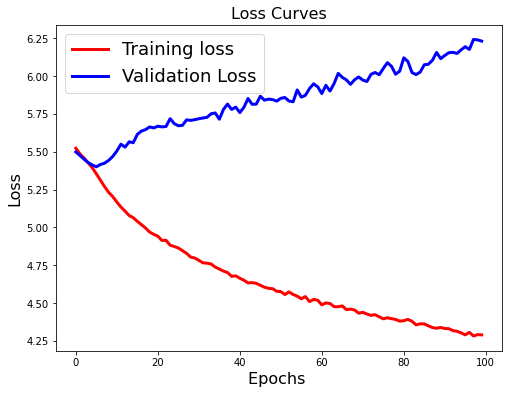

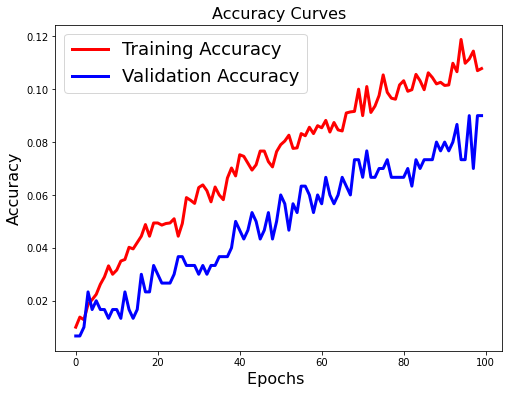

In [23]:
# Show model's loss and accuracy graph
loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=[8,6])
plt.plot(loss,'r',linewidth=3.0)
plt.plot(val_loss,'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.show()

plt.figure(figsize=[8,6])
plt.plot(accuracy,'r',linewidth=3.0)
plt.plot(val_accuracy,'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)
plt.show() 